1. I acquired this dataset from https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset/data. This code is a multi-label classification with 4 distinct labels. I chose this project because of the similarities to my own research of image quality labels, but I could not share this dataset due to compliance reasons.

2. I am going to use transfer learning with VGG19. This method has been shown to work well with MRI classification (Comparison of Machine Learning and Deep Learning for View Identification from Cardiac Magnetic Resonance Images Chauhan D et al https://pmc.ncbi.nlm.nih.gov/articles/PMC8849564/). Since VGG19 takes a long time to train, I will use a batch size of 256 with 15 epochs. I will then add a dropout layer to try and avoid overfitting and compare with my standard model. I will then evaluate the test dataset.

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.image as img
from sklearn.model_selection import train_test_split
import tensorflow as tf
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint, LambdaCallback





# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
#Load and sort the code into train and test images and labels
train_dir = '/kaggle/input/brain-tumor-mri-dataset/Training'
test_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing'

glioma_jpg_dir = '/glioma/'
meningioma_jpg_dir = '/meningioma/'
notumor_jpg_dir = '/notumor/'
pituitary_jpg_dir = '/pituitary/'



train_tif_dir = '/kaggle/input/histopathologic-cancer-detection/train'
test_tif_dir = '/kaggle/input/histopathologic-cancer-detection/test'


In [ ]:
#Here I am transforming into a dataframe
Train = pd.DataFrame(columns = ['path','id','label'])
Test = pd.DataFrame(columns = ['path','id','label'])
j = 0
for i in os.listdir(train_dir + glioma_jpg_dir):
    Train = pd.concat([pd.DataFrame([[train_dir + glioma_jpg_dir + str(i),str(i),'glioma']],columns = Train.columns),Train], ignore_index=True)
for i in os.listdir(train_dir + meningioma_jpg_dir):
    Train = pd.concat([pd.DataFrame([[train_dir + meningioma_jpg_dir + str(i),str(i),'meningioma']],columns = Train.columns),Train], ignore_index=True)
for i in os.listdir(train_dir + notumor_jpg_dir):
    Train = pd.concat([pd.DataFrame([[train_dir + notumor_jpg_dir + str(i),str(i),'notumor']],columns = Train.columns),Train], ignore_index=True)
for i in os.listdir(train_dir + pituitary_jpg_dir):
    Train = pd.concat([pd.DataFrame([[train_dir + pituitary_jpg_dir + str(i),str(i),'pituitary']],columns = Train.columns),Train], ignore_index=True)
for i in os.listdir(test_dir + glioma_jpg_dir):
    Test = pd.concat([pd.DataFrame([[test_dir + glioma_jpg_dir + str(i),str(i),'glioma']],columns = Test.columns),Test], ignore_index=True)
for i in os.listdir(test_dir + meningioma_jpg_dir):
    Test = pd.concat([pd.DataFrame([[test_dir + meningioma_jpg_dir + str(i),str(i),'meningioma']],columns = Test.columns),Test], ignore_index=True)
for i in os.listdir(test_dir + notumor_jpg_dir):
    Test = pd.concat([pd.DataFrame([[test_dir + notumor_jpg_dir + str(i),str(i),'notumor']],columns = Test.columns),Test], ignore_index=True)
for i in os.listdir(test_dir + pituitary_jpg_dir):
    Test = pd.concat([pd.DataFrame([[test_dir + pituitary_jpg_dir + str(i),str(i),'pituitary']],columns = Test.columns),Test], ignore_index=True)
print(Train.describe())
print(Test.describe())

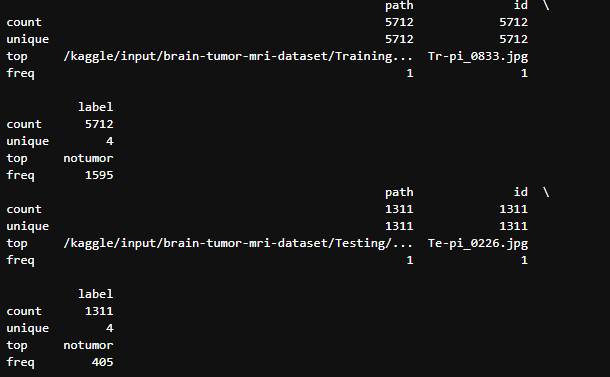

In [ ]:
plt.hist(Train['label'], 7)
plt.xlabel('Tumor Presence Index')
plt.xticks(ticks=[0.2, 1.05, 1.92, 2.78],labels=['Pituitary','No Tumor','Menigioma','Glioma'])
plt.ylabel('# of Cases in Train Dataset')
plt.title('Prevalence of various tumor diagnosis in Training Dataset')

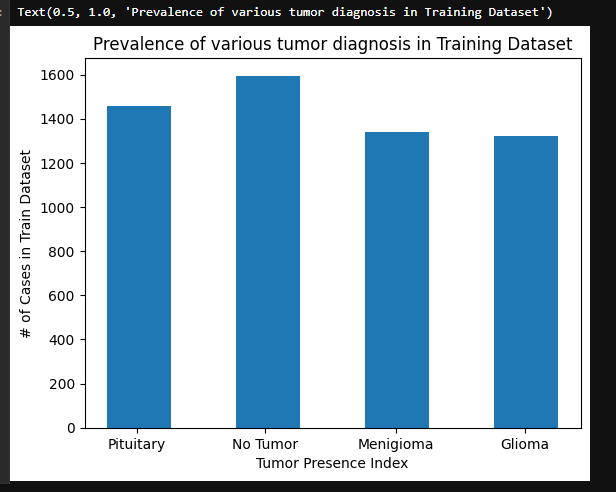

In [ ]:
Train_df, Val_df = train_test_split(Train, test_size=0.25, random_state=31, shuffle=True)

plt.hist(Train_df['label'], 7)
plt.xlabel('Train Tumor Presence Index')
plt.xticks(ticks=[0.2, 1.05, 1.92, 2.78],labels=['Pituitary','No Tumor','Menigioma','Glioma'])
plt.ylabel('# of Cases in Train Dataset')
plt.title('Prevalence of various tumor diagnosis in Training Dataset')

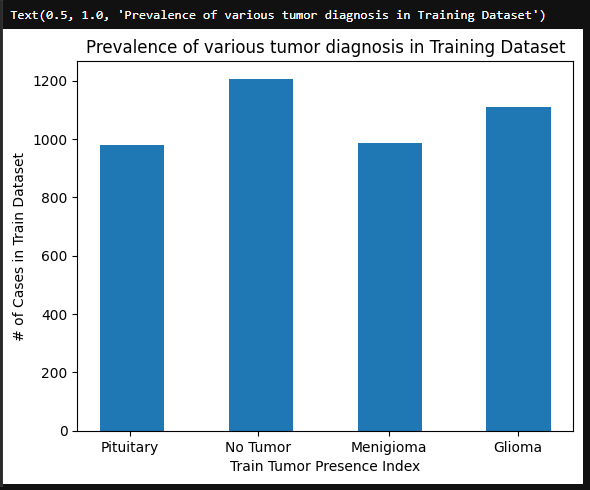

In [ ]:
plt.hist(Val_df['label'], 7)
plt.xlabel('Train Tumor Presence Index')
plt.xticks(ticks=[0.2, 1.05, 1.92, 2.78],labels=['Pituitary','No Tumor','Menigioma','Glioma'])
plt.ylabel('# of Cases in Train Dataset')
plt.title('Prevalence of various tumor diagnosis in Training Dataset')

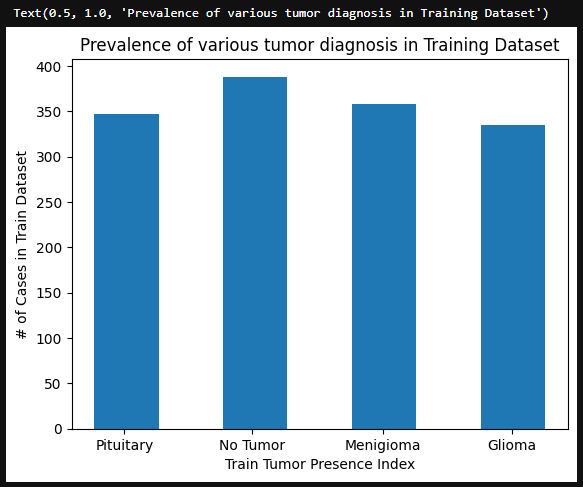

All of the datasets have roughly the same proportions of each label, so I've decided to not worry about their distribution. 

In [ ]:
max_x = 0
min_x = 1000
max_y = 0
min_y = 1000
for i in range(len(Train)):
    img_temp = img.imread(Train['path'][i])
    size_temp = np.shape(img_temp)
    min_x = min(size_temp[0],min_x)
    min_y = min(size_temp[1],min_y)

for i in range(len(Test)):
    img_temp = img.imread(Test['path'][i])
    size_temp = np.shape(img_temp)
    min_x = min(size_temp[0],min_x)
    min_y = min(size_temp[1],min_y)
        
print(min_x)
print(min_y)


In [ ]:

im_temp = img.imread(Train['path'][234])
print(im_temp.shape)

3.
This dataset comprises of MRI images containing a wide variety of image sizes. In order to make it consistent, I will make all images 128x128, smaller than any image in the dataset (150, 168 minimums), in order to have uniform image transform direction. This will take place in the next step by setting the target size to 128x128 in the flow_from_dataframe.

Since I am using image data, I will need to rescale the [0:255] to [0:1] in order for easier processing.

None of the data needs to be discarded as I am interpolating all of the images to 128x128. 

Since the minimum dimensions are 150 and 168, I am going to reshape all images to be 128x128 to pass into the model.

In [ ]:
Preprocessed_images = ImageDataGenerator(rescale=1./255, validation_split=0.25)
batch_size=256
Train_images = Preprocessed_images.flow_from_dataframe(dataframe=Train_df, x_col='path', y_col='label', batch_size=batch_size, class_mode='categorical', target_size=(128,128), color_mode='rgb', validate_filenames=False)
Validation_images = Preprocessed_images.flow_from_dataframe(dataframe=Val_df, x_col='path', y_col='label', batch_size=batch_size, class_mode='categorical', target_size=(128,128), color_mode='rgb', validate_filenames=False)

#print(pd.DataFrame.shape(Train_images))

In my first attempt, I forgot to shuffle the dataset before training. I recognized the problem when I saw that val_accuracy was <20%, which could be achieved through assigning all images a single label. I recognized there was not proper distribution of labels between train and validation datasets, and corrected this at once.

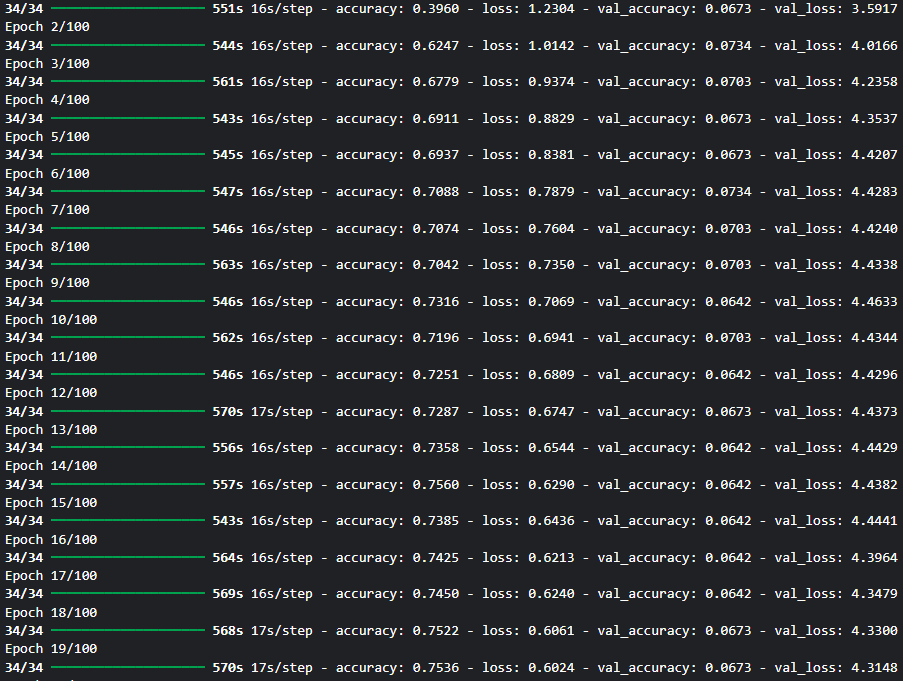

In [ ]:
vgg19_weights_path = '/kaggle/input/vgg19/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'

base_model = VGG19(weights=vgg19_weights_path, include_top=False, input_shape=(128,128,3)) #Makes pre-trained VGG model without layer
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(512, activation ='relu')(x)
prediction = Dense(4, activation='softmax')(x) #Single output node for scores from 0 to 3
batch_size = 256
model = Model(inputs=base_model.input, outputs=prediction) #Creating model with positive/negative output

for layer in base_model.layers:
    layer.trainable = False #Keeps weights frozen

model.compile(optimizer='sgd',loss='categorical_crossentropy',metrics=['accuracy']) #Compiles model with sgd optimization and Categorical Crossentropy loss function

model.fit(Train_images, validation_data = Validation_images, epochs=15)

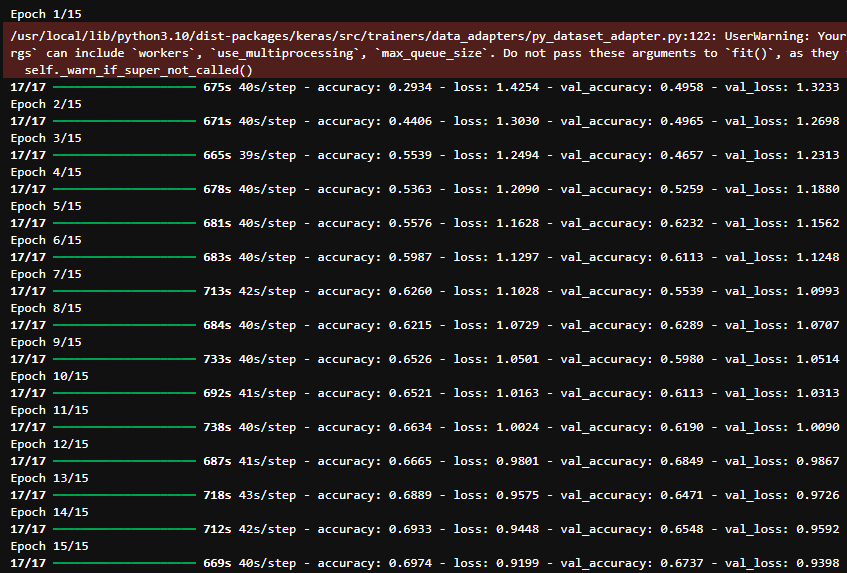

Above is a screenshot of the results of running this cell with the parameters listed. It took ~3 hours to train, and resulted in a val_accuracy of 0.6737 (much better than 0.07) Due to performance and timing constraints, I will be sticking with 15 epochs, even though validation loss kept decreasing over epochs. I will implement a dropout layer of 0.2 to see if I can increase accuracy and avoid overfitting.

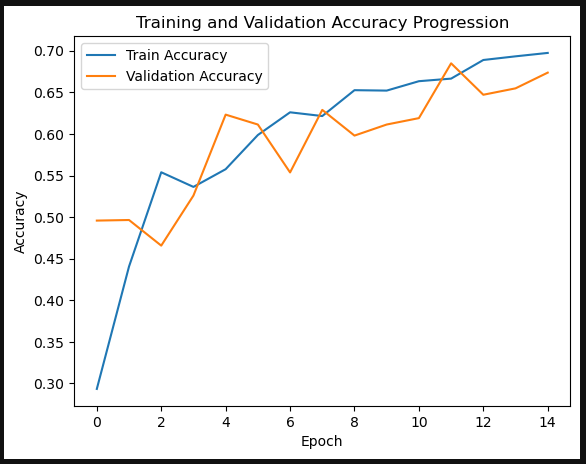

Plot generated outside of this notebook.

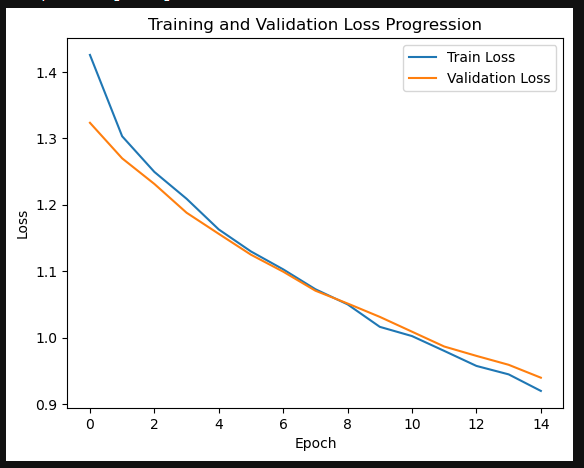

Plot generated outside of this notebook

In [ ]:
x_do = base_model.output
x_do = tf.keras.layers.GlobalAveragePooling2D()(x_do)
x_do = tf.keras.layers.Dropout(rate=0.2)(x_do)
x_do = Dense(512, activation ='relu')(x_do)
prediction_do = Dense(4, activation='softmax')(x_do) #Single output node for scores from 0 to 3
batch_size = 256
model_do = Model(inputs=base_model.input, outputs=prediction) #Creating model with positive/negative output

for layer in base_model.layers:
    layer.trainable = False #Keeps weights frozen

model_do.compile(optimizer='sgd',loss='categorical_crossentropy',metrics=['accuracy']) #Compiles model with sgd optimization and Categorical Crossentropy loss function

model_do.fit(Train_images, validation_data = Validation_images, epochs=15)

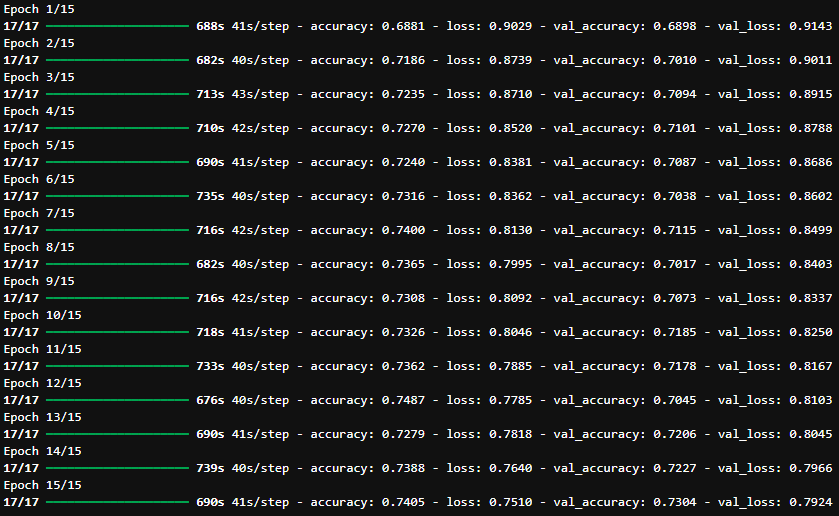

Above is a screenshot of the implementation of the VGG19 transfer learning with a dropout layer. It also took ~3 hours to train, but there was significant improvement in the validation accuracy and loss compared to without the dropout layer. 

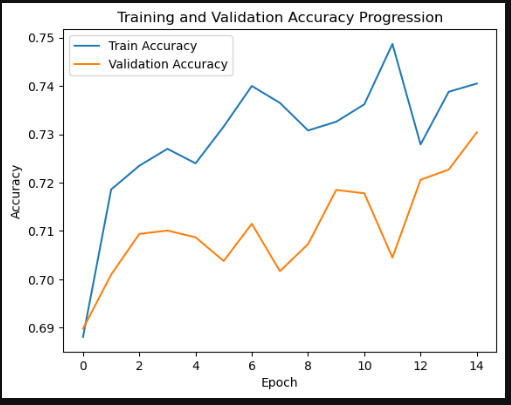

Plot generated outside of this notebook

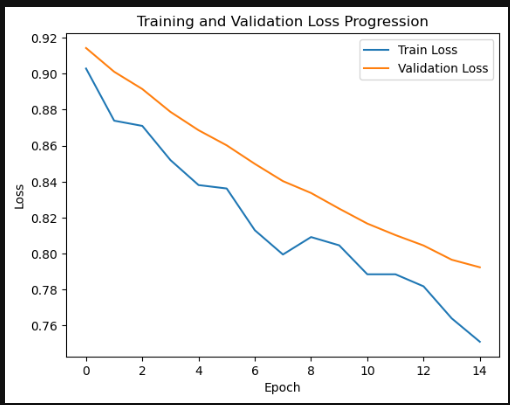

Plot generated outside of this notebook

In [ ]:
Test_images=Preprocessed_images.flow_from_dataframe(dataframe=Test, x_col='path', y_col='label', batch_size=batch_size, class_mode='categorical', target_size=(128,128), color_mode='rgb', validate_filenames=False)
Test_loss, Test_Accuracy = model_do.evaluate(Test_images)
print("Test Loss = " + str(Test_loss))
print("Test Accuracy = " + str(Test_Accuracy))

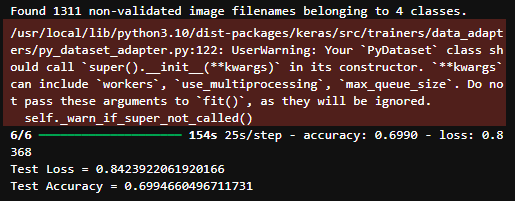

While the test accuracy was a few percentage points lower than the validation of the last epoch, it is reasonably close. The challenge here was the limited resources to run VGG_19 epochs, but it is a good model.